In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data/text.csv")

# visulize data

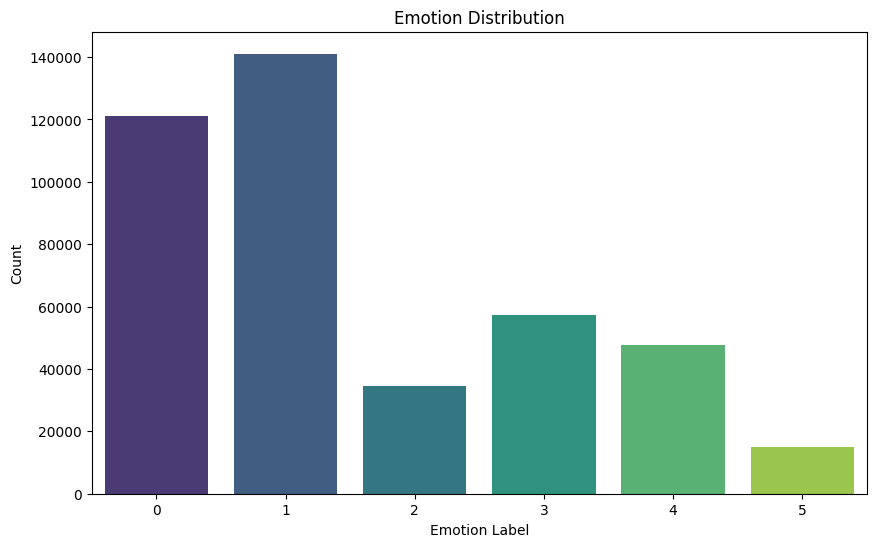

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Emotion Distribution')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.show()

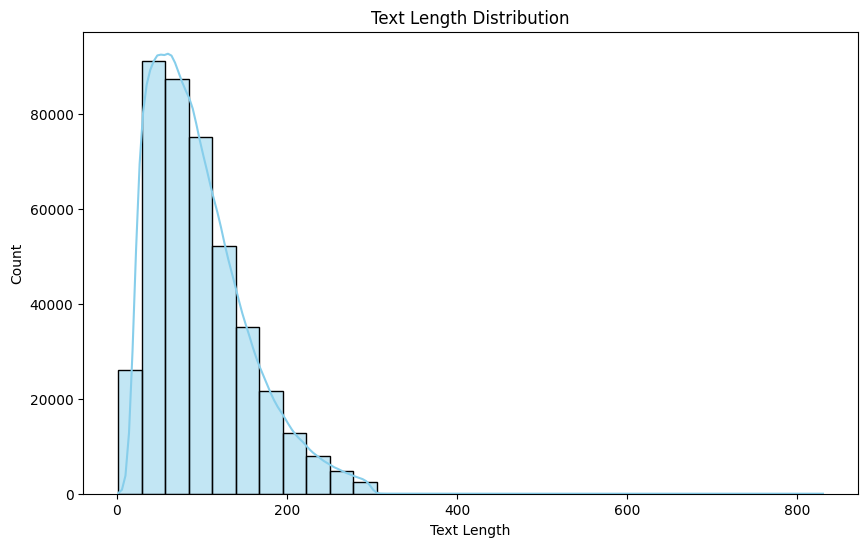

In [4]:
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df, x='text_length', bins=30, kde=True, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

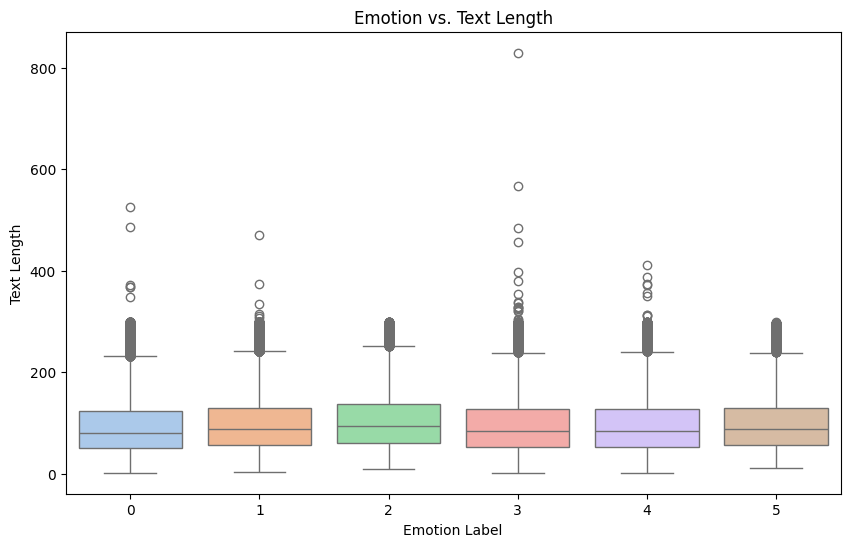

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df, palette='pastel')
plt.title('Emotion vs. Text Length')
plt.xlabel('Emotion Label')
plt.ylabel('Text Length')
plt.show()

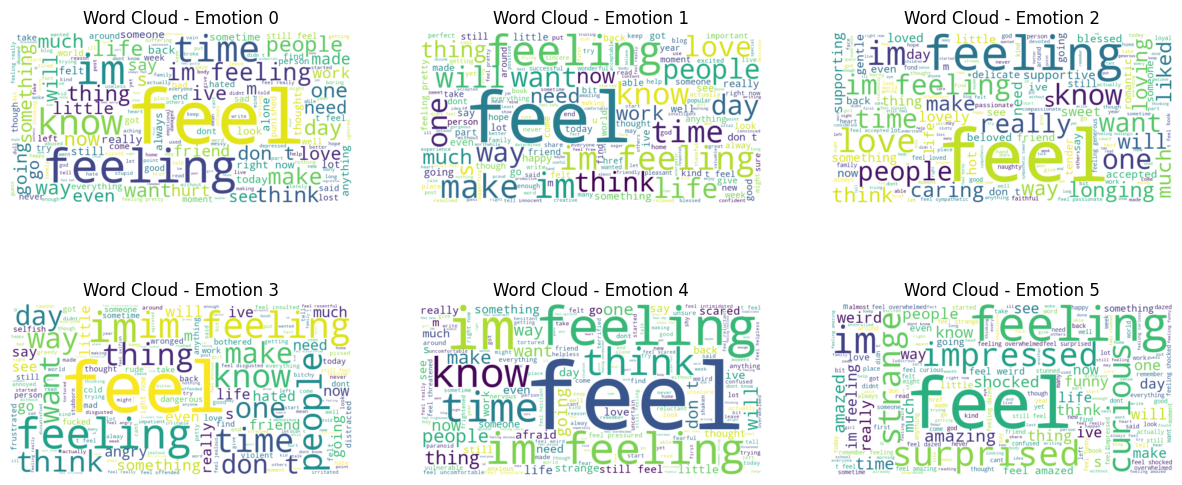

In [6]:
from wordcloud import WordCloud

emotions = df['label'].unique()
plt.figure(figsize=(15, 10))
for emotion in emotions:
    subset = df[df['label'] == emotion]
    text = ' '.join(subset['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(3, 3, emotion+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Emotion {emotion}')
    plt.axis('off')
plt.show()

# prepare

In [7]:
from sklearn.model_selection import KFold

In [8]:
X = df['text']
y = df['label']

In [9]:
# Convert labels to one-hot encoding
y_encoded = to_categorical(y)

In [10]:
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_vec = vectorizer.fit_transform(X)

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
accuracy_scores = []
classification_reports = []
confusion_matrices = []

# model

In [12]:
# Define the neural network model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_encoded.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
# Implement early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for train_index, test_index in kf.split(X_vec):
    X_train, X_test = X_vec[train_index], X_vec[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=-1)
    y_test_classes = y_test.argmax(axis=-1)
    
    accuracy_scores.append(accuracy_score(y_test_classes, y_pred_classes))
    classification_reports.append(classification_report(y_test_classes, y_pred_classes, output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test_classes, y_pred_classes))

Epoch 1/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 186s 18ms/step - accuracy: 0.8395 - loss: 0.4185 - val_accuracy: 0.9014 - val_loss: 0.1947
Epoch 2/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 190s 18ms/step - accuracy: 0.9059 - loss: 0.1988 - val_accuracy: 0.9049 - val_loss: 0.1939
Epoch 3/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 192s 18ms/step - accuracy: 0.9124 - loss: 0.1787 - val_accuracy: 0.9058 - val_loss: 0.1919
Epoch 4/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 189s 18ms/step - accuracy: 0.9190 - loss: 0.1638 - val_accuracy: 0.9030 - val_loss: 0.1969
Epoch 5/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 190s 18ms/step - accuracy: 0.9224 - loss: 0.1555 - val_accuracy: 0.9036 - val_loss: 0.2073
Epoch 6/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 190s 18ms/step - accuracy: 0.9242 - loss: 0.1488 - val_accuracy: 0.9007 - val_loss: 0.2122
2606/2606 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/50
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 191s 18ms/step - accuracy: 0.8414 - loss: 0.4130 - val_accuracy: 0.8975 - val_loss: 0.1988
Epoch 2/50
1

In [14]:
# %%
print("\nModel Evaluation:")
print("Average Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
print("\nClassification Reports:")
for i, report in enumerate(classification_reports):
    print(f"\nFold {i+1}:\n", pd.DataFrame(report).transpose())
print("\nConfusion Matrices:")
for i, matrix in enumerate(confusion_matrices):
    print(f"\nFold {i+1}:\n", matrix)


Model Evaluation:
Average Accuracy: 0.9009186426654419

Classification Reports:

Fold 1:
               precision    recall  f1-score       support
0              0.942588  0.936996  0.939784  23935.000000
1              0.900585  0.960127  0.929403  28390.000000
2              0.928961  0.685382  0.788795   6964.000000
3              0.871247  0.959711  0.913342  11641.000000
4              0.937780  0.775707  0.849078   9443.000000
5              0.723513  0.854466  0.783556   2989.000000
accuracy       0.905796  0.905796  0.905796      0.905796
macro avg      0.884112  0.862065  0.867326  83362.000000
weighted avg   0.908783  0.905796  0.904066  83362.000000

Fold 2:
               precision    recall  f1-score       support
0              0.917271  0.951044  0.933852  24471.000000
1              0.958977  0.875244  0.915199  28151.000000
2              0.711532  0.977167  0.823457   6876.000000
3              0.898888  0.905547  0.902205  11339.000000
4              0.925267  0.78